# SwarmPRM  + Time

In [1]:
%matplotlib inline

## Road Map tests


#### Import and setup

In [2]:
import glob
from matplotlib import pyplot as plt
import numpy as np

from swarm_prm.envs.map import MapLoader
from swarm_prm.envs.instance import Instance
from swarm_prm.solvers.swarm_prm.macro.gaussian_utils import GaussianGraphNode
from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianPRM


### Visualizing Maps

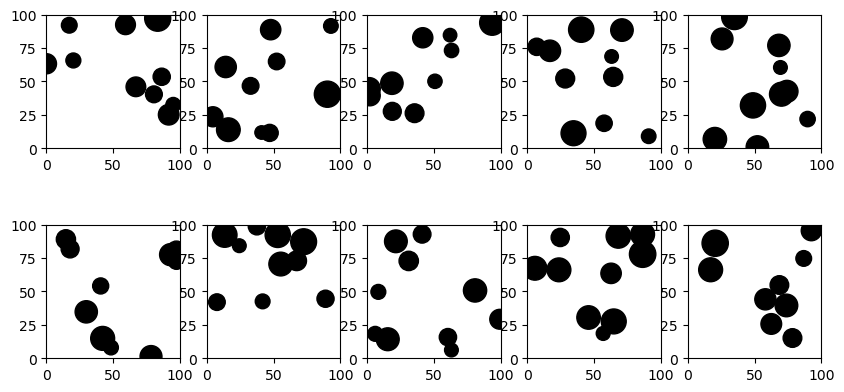

In [3]:
map_dir = "data/envs/maps/*"

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

# Visualize the first 10 maps
for idx, map_fname in enumerate(glob.glob(map_dir)[:10]):
    row = idx // 5
    col = idx % 5
    map_loader = MapLoader(map_fname)
    map = map_loader.get_map()
    map.visualize(ax=axs[row][col])

### Curated example

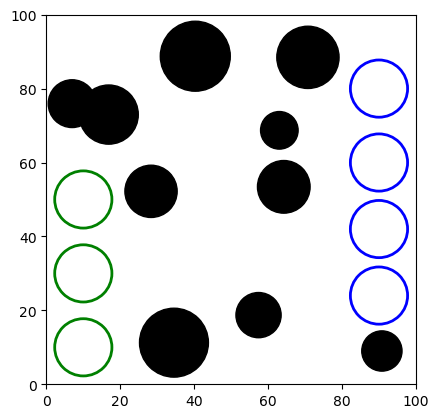

In [4]:
### PARAMETERS ###

# Map config
map_fname = "data/envs/maps/map_7.yaml"
map_loader = MapLoader(map_fname)
map = map_loader.get_map()
num_samples = 500 # number of sample points

# Agent config
num_agent = 100
agent_radius = 1
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 30], [10, 50]])
goals = np.array([[90, 42], [90, 60], [90, 80], [90, 24]])

starts_weight = np.array([0.3, 0.4, 0.3])
goals_weight = np.array([0.1, 0.2, 0.4, 0.3])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(map, g_starts, g_goals, starts_weight, goals_weight, num_agent)
instance.visualize()



#### Sampling Roadmap



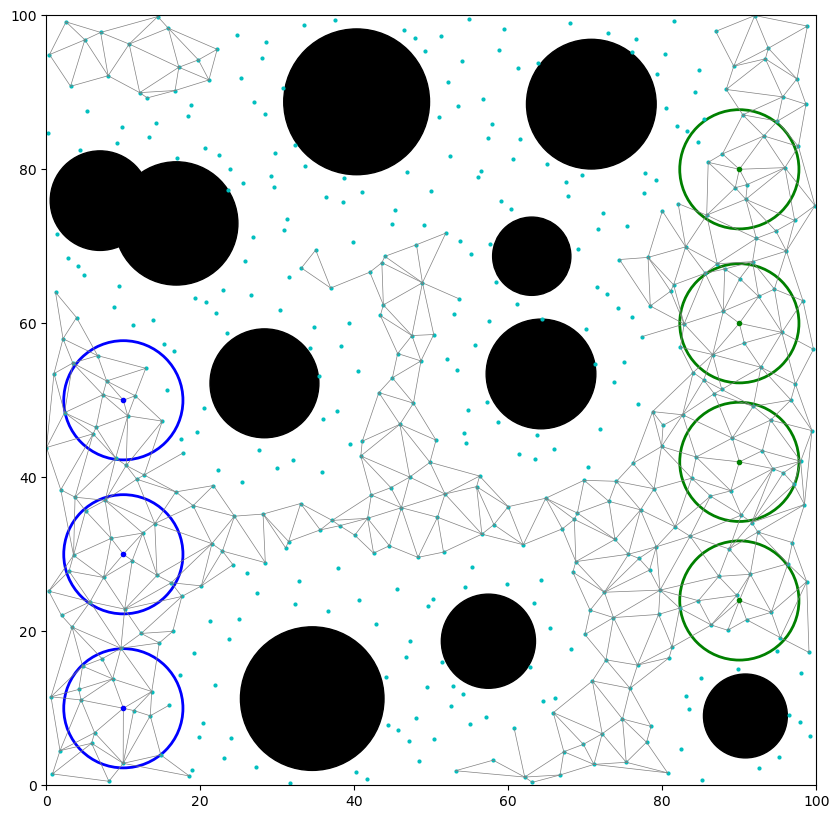

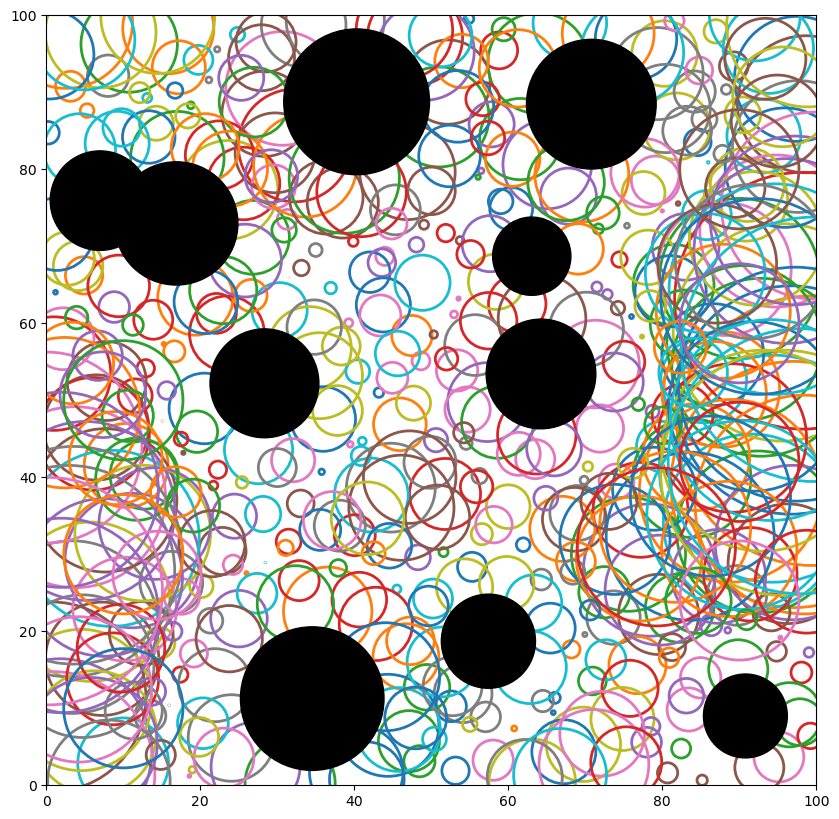

In [5]:
# Swarm PRM sampling method
if sampling_method == "SWARMPRM_SAMPLING":
    gaussian_prm = GaussianPRM(instance, num_samples)
    gaussian_prm.sample_free_space(sampling_strategy="SWARMPRM")
    gaussian_prm.load_instance()
    gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
    gaussian_prm.visualize_roadmap("test_map")
    gaussian_prm.visualize_g_nodes("test_g_nodes")

# Gaussian distribution with unit covariance 
elif sampling_method == "GAUSSIAN_SAMPLING":
    gaussian_prm = GaussianPRM(instance, num_samples)
    gaussian_prm.sample_free_space(sampling_strategy="UNIFORM_HALTON")
    gaussian_prm.load_instance()
    gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
    gaussian_prm.visualize_roadmap("test_map")
    gaussian_prm.visualize_g_nodes("test_g_nodes")




### TEG 

In [6]:
from swarm_prm.solvers.swarm_prm.macro.teg_nx import TEGGraph_NX

teg_graph= TEGGraph_NX(gaussian_prm, agent_radius, target_flow=num_agent)
max_flow, flow_dict, timestep, teg, restricted_edges  = teg_graph.find_earliest_timestep()
print("max flow", max_flow)
print("timestep", timestep)
print("flow_dict", flow_dict)
assert max_flow is not None, "Unable to find solution within the given timesteps"


timestep: 0 max_flow: 0
timestep: 1 max_flow: 0
timestep: 2 max_flow: 0
timestep: 3 max_flow: 0
timestep: 4 max_flow: 0
timestep: 5 max_flow: 0
timestep: 6 max_flow: 0
timestep: 7 max_flow: 0
timestep: 8 max_flow: 0
timestep: 9 max_flow: 0
timestep: 10 max_flow: 0
timestep: 11 max_flow: 0
timestep: 12 max_flow: 0
timestep: 13 max_flow: 0
timestep: 14 max_flow: 0
timestep: 15 max_flow: 0
timestep: 16 max_flow: 0
timestep: 17 max_flow: 0
timestep: 18 max_flow: 0
timestep: 19 max_flow: 1
timestep: 20 max_flow: 5
timestep: 21 max_flow: 9
timestep: 22 max_flow: 14
timestep: 23 max_flow: 19
timestep: 24 max_flow: 24
timestep: 25 max_flow: 29
timestep: 26 max_flow: 34
timestep: 27 max_flow: 39
timestep: 28 max_flow: 44
timestep: 29 max_flow: 49
timestep: 30 max_flow: 54
timestep: 31 max_flow: 59
timestep: 32 max_flow: 64
timestep: 33 max_flow: 69
timestep: 34 max_flow: 74
timestep: 35 max_flow: 79
timestep: 36 max_flow: 84
timestep: 37 max_flow: 89
timestep: 38 max_flow: 94
timestep: 39 max_f

In [7]:
# gaussian_prm.visualize_solution(flow_dict, timestep, num_agent)

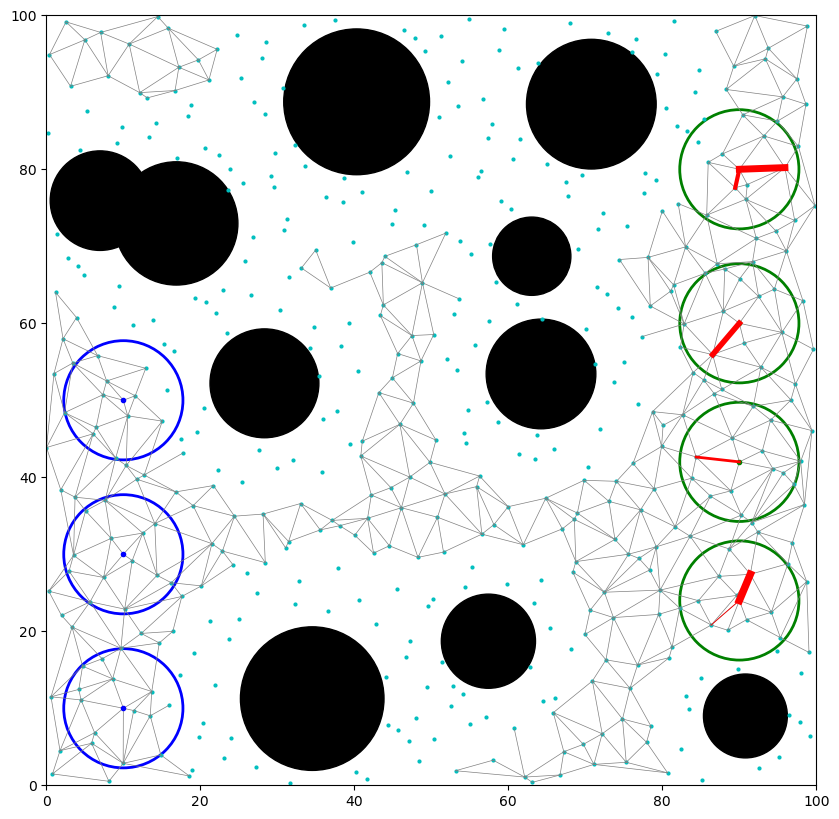

In [8]:
gaussian_prm.animate_solution(flow_dict, timestep, num_agent)

### APR Test

/tmp/ipykernel_20230/3440899824.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  U_rep += k_rep * (1.0 / dist - 1.0 / d0) ** 2


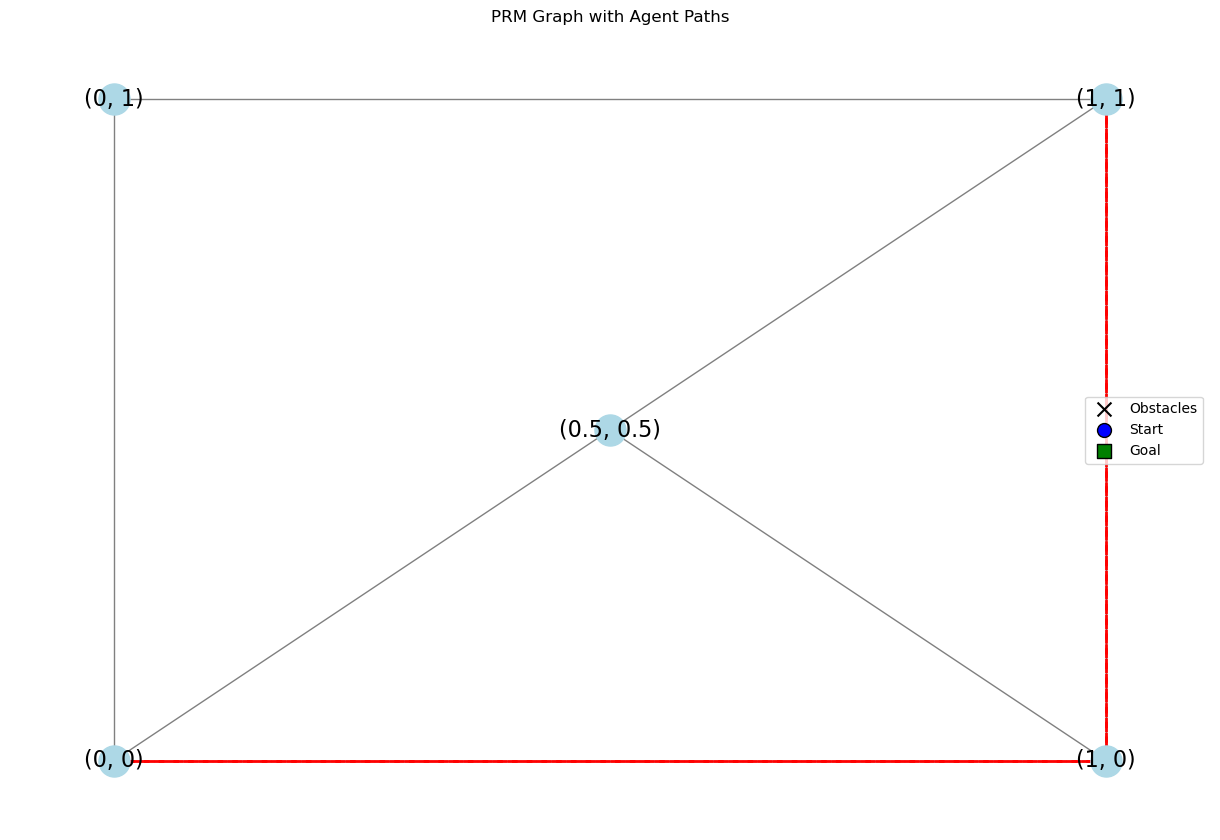

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the potential field functions
def attractive_potential(x, goal, k_att=1.0):
    return k_att * np.linalg.norm(x - goal)

def repulsive_potential(x, obstacles, k_rep=100.0, d0=1.0):
    U_rep = 0
    for obs in obstacles:
        dist = np.linalg.norm(x - obs)
        if dist < d0:
            U_rep += k_rep * (1.0 / dist - 1.0 / d0) ** 2
    return U_rep

def potential_field(x, goal, obstacles):
    U_att = attractive_potential(x, goal)
    U_rep = repulsive_potential(x, obstacles)
    return U_att + U_rep

# Generate PRM Graph
def create_prm_graph(nodes, edges):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    return G

# Define the pathfinding function using the potential field
def pathfinding(start, goal, graph, obstacles):
    path = [start]
    current = start
    while np.linalg.norm(np.array(current) - np.array(goal)) > 0.1:
        neighbors = list(graph.neighbors(current))
        if not neighbors:
            break
        best_next = None
        best_potential = float('inf')
        for neighbor in neighbors:
            potential = potential_field(np.array(neighbor), goal, obstacles)
            if potential < best_potential:
                best_potential = potential
                best_next = neighbor
        if best_next is None:
            break
        path.append(best_next)
        current = best_next
    path.append(goal)
    return path

# Define the environment
nodes = [(0, 0), (1, 0), (1, 1), (0, 1), (0.5, 0.5)]
edges = [((0, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 1), (0, 1)), ((0, 1), (0, 0)), ((0, 0), (0.5, 0.5)), ((1, 0), (0.5, 0.5)), ((1, 1), (0.5, 0.5))]
start_positions = [(0, 0), (1, 1)]
goal_positions = [(1, 1), (0, 0)]
obstacles = [(0.5, 0.5)]  # For simplicity, consider one obstacle

# Create PRM graph
graph = create_prm_graph(nodes, edges)

# Find paths for each agent
paths = []
for start, goal in zip(start_positions, goal_positions):
    path = pathfinding(start, goal, graph, obstacles)
    paths.append(path)

# Visualization
plt.figure(figsize=(12, 8))
pos = {node: node for node in nodes}
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, edge_color='gray')

# Draw paths
for path in paths:
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2, style='dashed')

# Draw obstacles
if obstacles:
    plt.scatter(*zip(*obstacles), color='black', marker='x', s=100, label='Obstacles')

# Draw start and goal points
for start, goal in zip(start_positions, goal_positions):
    plt.scatter(*start, color='blue', marker='o', s=100, edgecolor='black', label='Start' if 'Start' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.scatter(*goal, color='green', marker='s', s=100, edgecolor='black', label='Goal' if 'Goal' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title("PRM Graph with Agent Paths")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()
